In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.feature import hog
from skimage.transform import resize
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.special import rel_entr

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Image folder path
image_folder = '/content/drive/My Drive/Image Analysis/imageset2/'

# Image file names
image_files = ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg','9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg','17.jpg', '18.jpg', '19.jpg','20.jpg']

In [28]:
# HOG Feature extraction parameters
orientations = 9  # Number of orientation bins
pixels_per_cell = (8, 8)  # Size of a cell (in pixels)
cells_per_block = (2, 2)  # Number of cells in each block
resize_shape = (128, 128)  # Resize all images to 128x128 pixels

In [29]:
# List to store HOG feature vectors
hog_features = []

# Loop through each image file
for file in image_files:
    file_path = os.path.join(image_folder, file)

    # Load the image in grayscale
    img = imread(file_path, as_gray=True)

    # Resize the image to a fixed size
    img_resized = resize(img, resize_shape)

    # Extract HOG features
    hog_feature, hog_image = hog(img_resized, orientations=orientations, pixels_per_cell=pixels_per_cell,
                                 cells_per_block=cells_per_block, visualize=True, block_norm='L2-Hys')

    # Append the HOG feature vector to the list
    hog_features.append(hog_feature)

# Convert HOG features list to a numpy array
hog_features = np.array(hog_features)

In [30]:
# Jensen-Shannon Divergence function using KL divergence
def jensen_shannon_distance(p, q):
    """Calculate the Jensen-Shannon divergence between two vectors."""
    p = np.array(p) / np.sum(p)  # Normalize
    q = np.array(q) / np.sum(q)  # Normalize
    m = 0.5 * (p + q)
    return 0.5 * (np.sum(rel_entr(p, m)) + np.sum(rel_entr(q, m)))

In [31]:
# Compute the distance matrix (8x8 since we have 8 images)
num_images = len(hog_features)
distance_matrix = np.zeros((num_images, num_images))

In [32]:
# Fill the distance matrix using Jensen-Shannon divergence
for i in range(num_images):
    for j in range(i+1, num_images):
        dist = jensen_shannon_distance(hog_features[i], hog_features[j])
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist  # Symmetric matrix


In [33]:
# Convert distance matrix to condensed form (needed for clustering)
condensed_distance_matrix = squareform(distance_matrix)

In [34]:
# Function to plot dendrogram for different linkage methods
def plot_dendrogram(linkage_method):
    plt.figure(figsize=(15, 7))
    linkage_matrix = linkage(condensed_distance_matrix, method=linkage_method)
    dendrogram(linkage_matrix, labels=image_files)
    plt.title(f'Hierarchical Clustering Dendrogram ({linkage_method.capitalize()})')
    plt.xlabel('Image Index')
    plt.ylabel('Distance')
    plt.show()

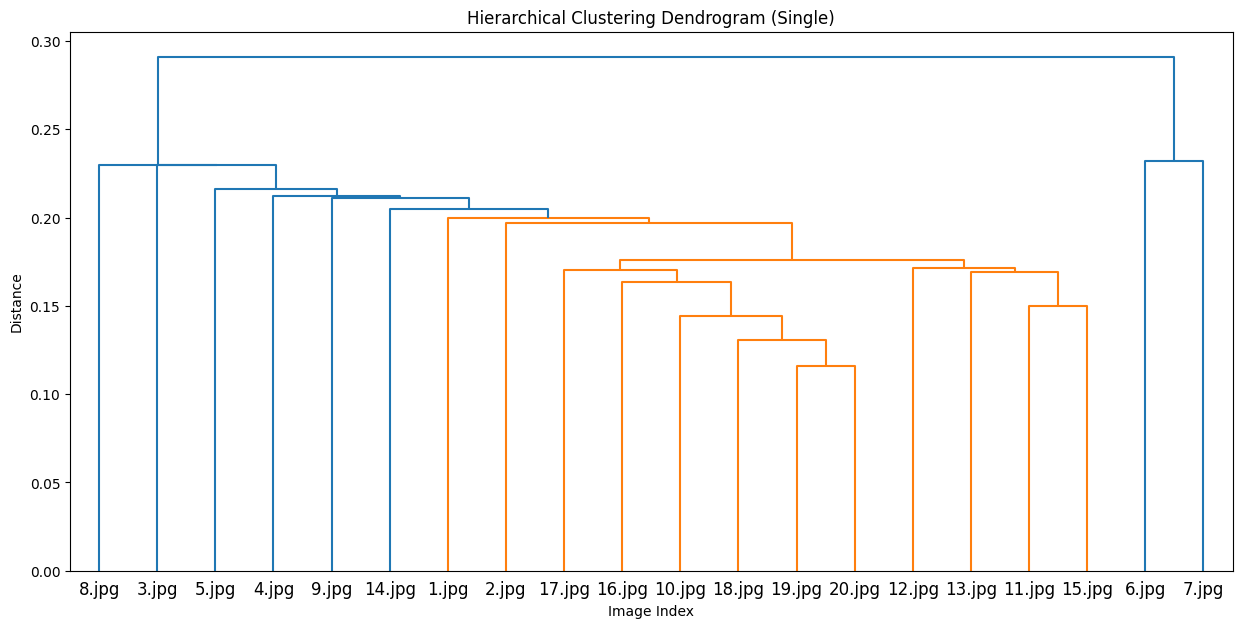

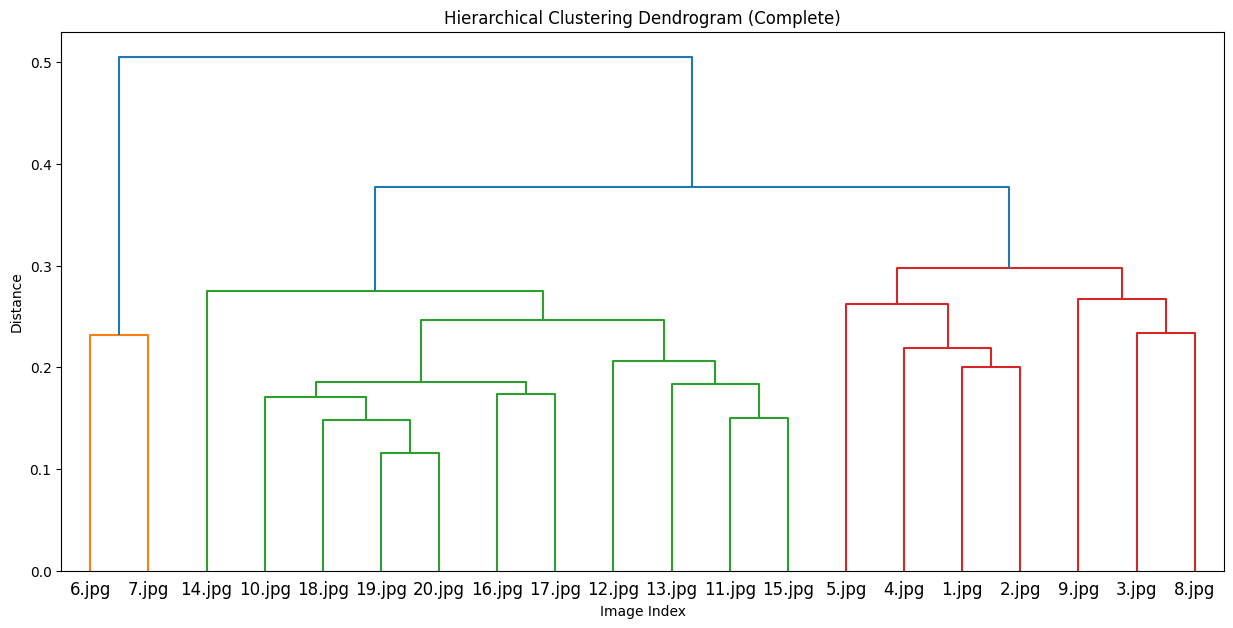

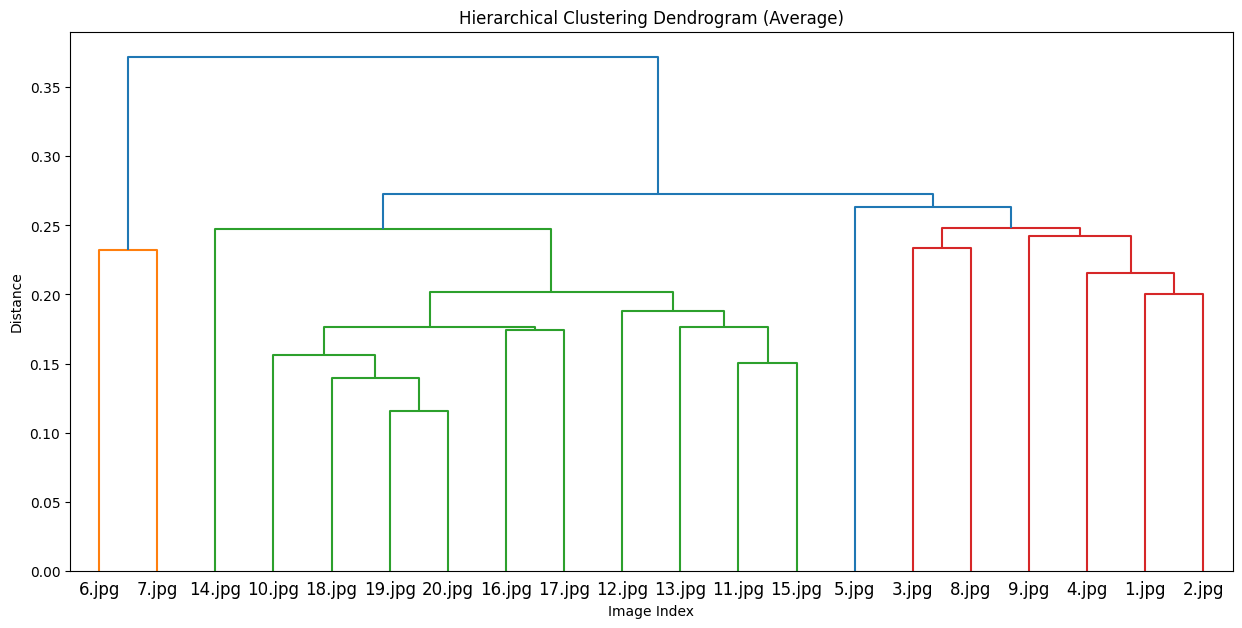

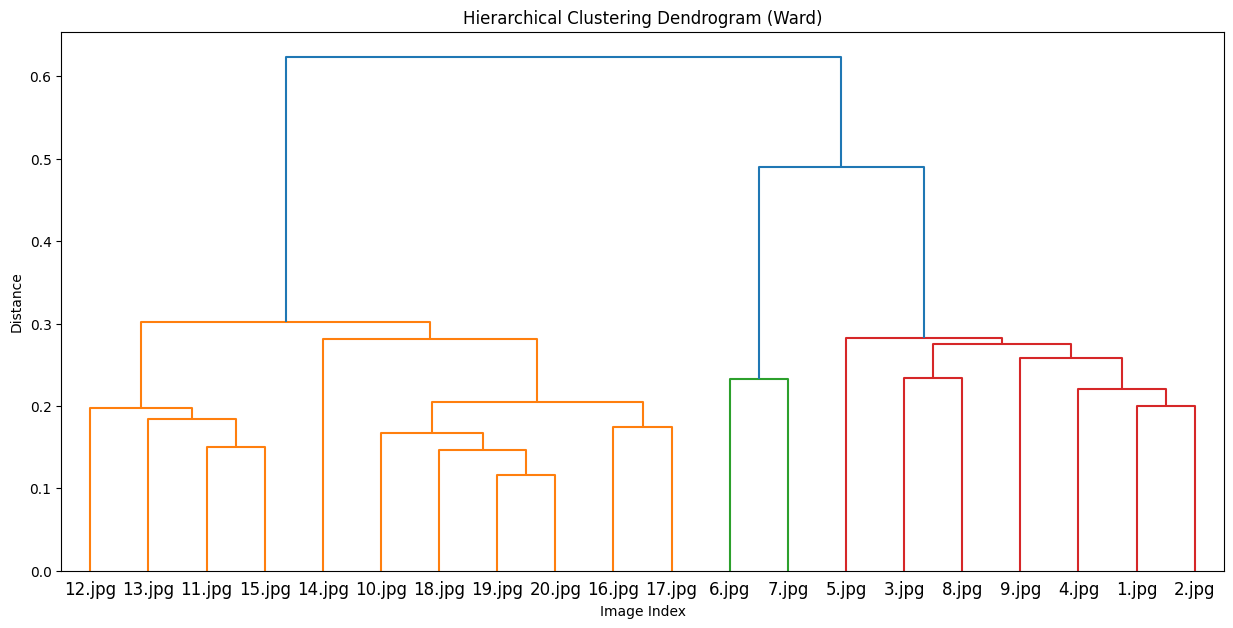

In [35]:
# Perform and plot dendrograms for different linkage methods
linkage_methods = ['single', 'complete', 'average', 'ward']
for method in linkage_methods:
    plot_dendrogram(method)

Improving

<ipython-input-36-be9078d5a5f7>:25: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method=method)


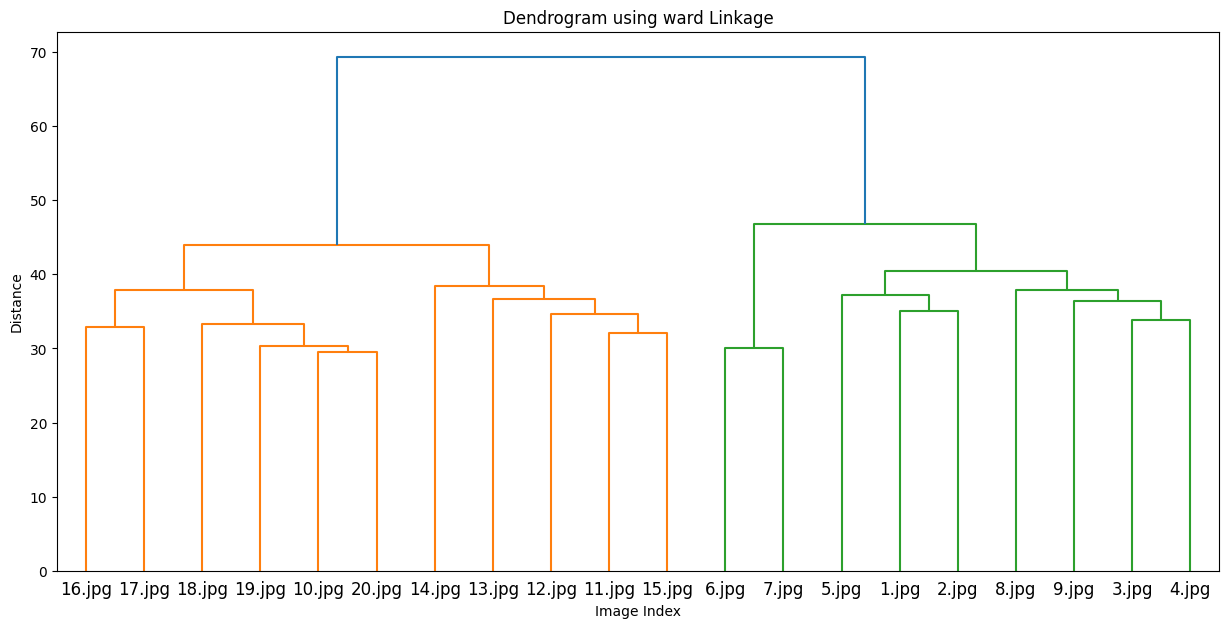

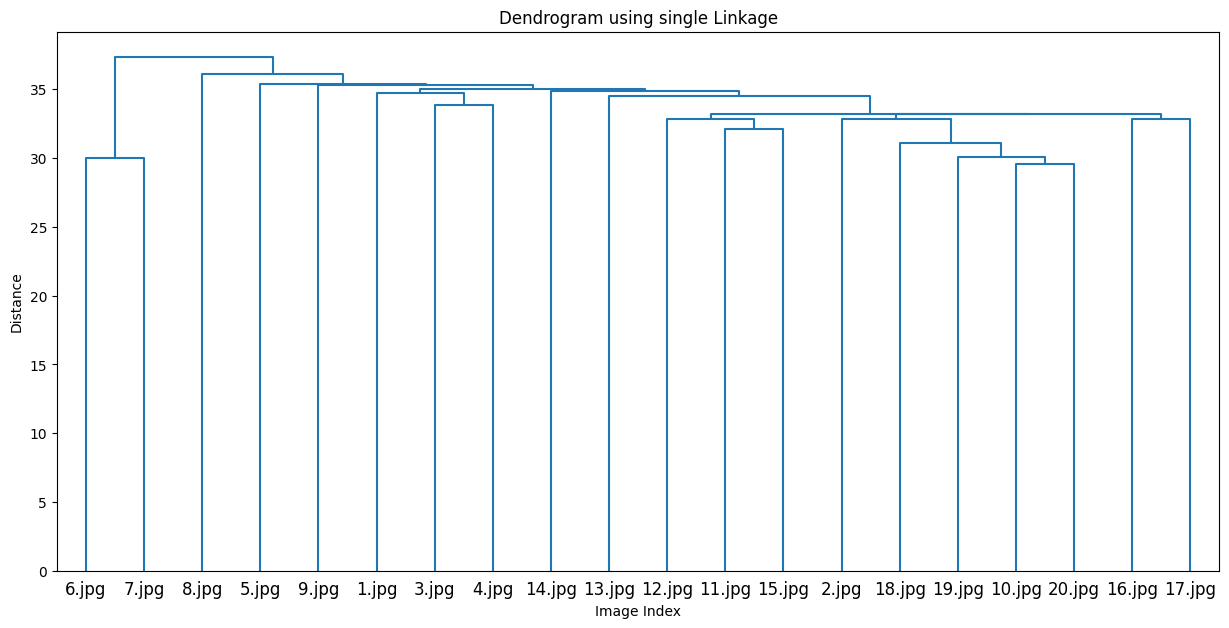

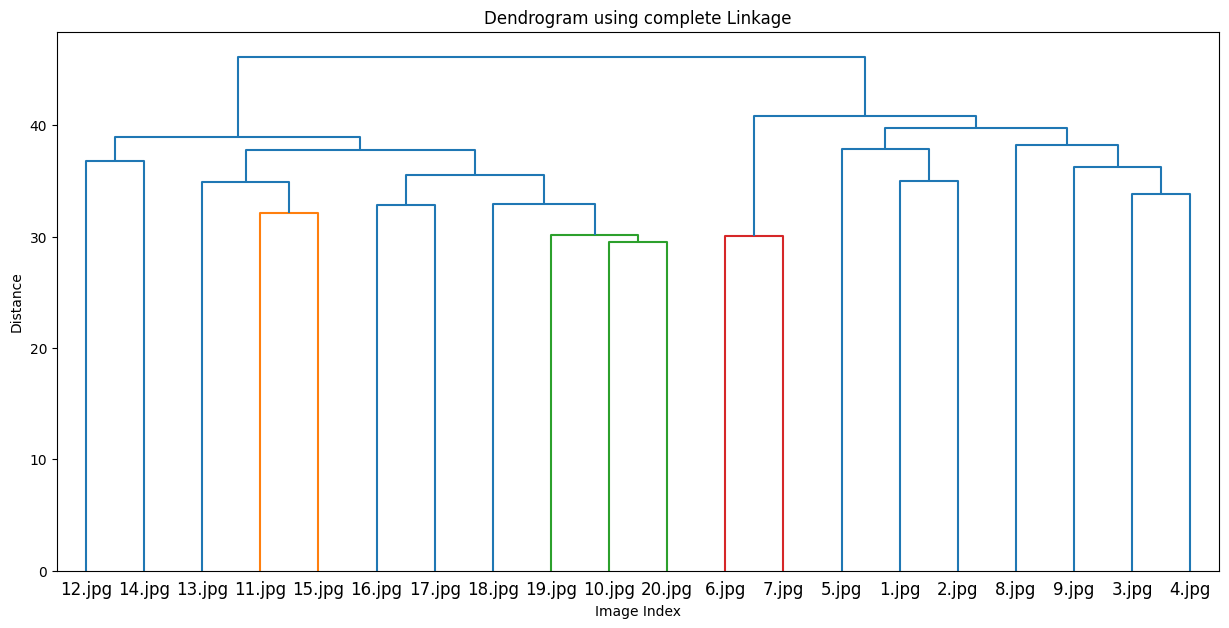

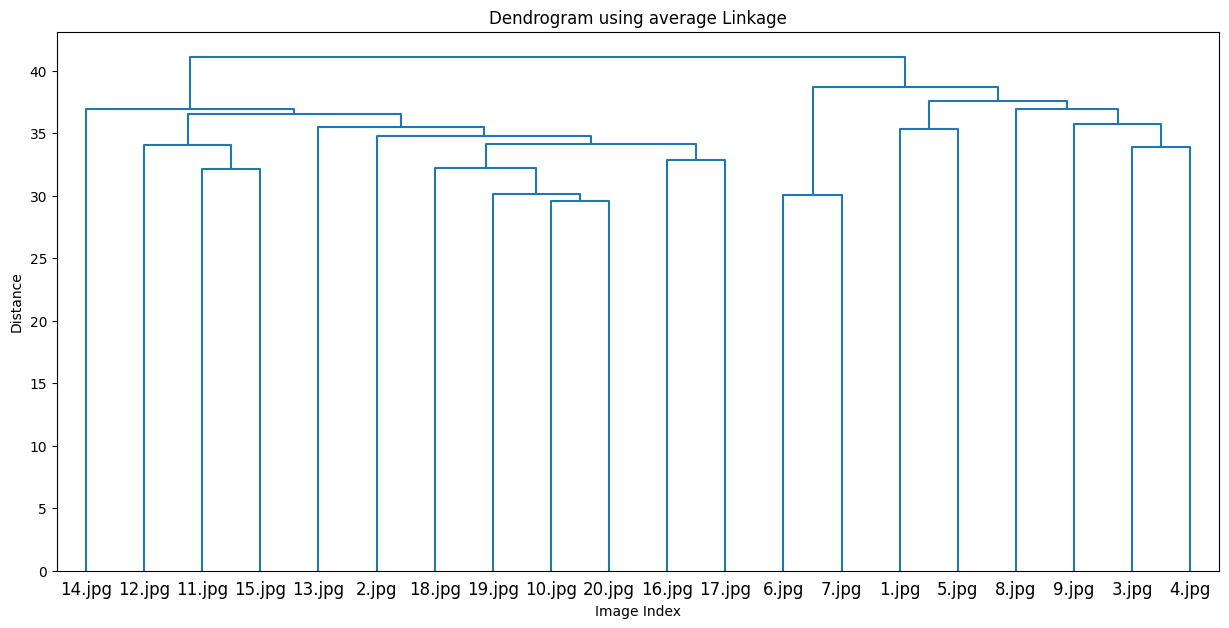

In [36]:
from scipy.spatial.distance import pdist

# Initialize list to hold HOG features
hog_features = []

# Feature extraction
for file in image_files:
    img = imread(os.path.join(image_folder, file), as_gray=True)
    img = resize(img, (224, 224))  # Resize image
    features, _ = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block, visualize=True, feature_vector=True)
    hog_features.append(features)

# Convert HOG features list to a numpy array
hog_features = np.array(hog_features)

# Compute the distance matrix using Euclidean distance
distance_matrix = pdist(hog_features, metric='euclidean')
distance_matrix = squareform(distance_matrix)

# Apply hierarchical clustering using different linkage methods
linkage_methods = ['ward', 'single', 'complete', 'average']
for method in linkage_methods:
    plt.figure(figsize=(15, 7))
    Z = linkage(distance_matrix, method=method)
    dendrogram(Z, labels=image_files)
    plt.title(f'Dendrogram using {method} Linkage')
    plt.xlabel('Image Index')
    plt.ylabel('Distance')
    plt.show()

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

orientations = 12  # Number of orientation bins
pixels_per_cell = (4, 4)  # Size of a cell (in pixels)
cells_per_block = (2, 2)  # Number of cells in each block

# Initialize list to hold HOG features
hog_features = []

# Feature extraction
for file in image_files:
    img = imread(os.path.join(image_folder, file), as_gray=True)
    img = resize(img, (224, 224))  # Resize image to 224x224
    features, _ = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block, visualize=True, feature_vector=True)
    hog_features.append(features)

# Convert HOG features list to a numpy array
hog_features = np.array(hog_features)

# Normalize HOG features to ensure consistent scaling
scaler = StandardScaler()
hog_features_scaled = scaler.fit_transform(hog_features)


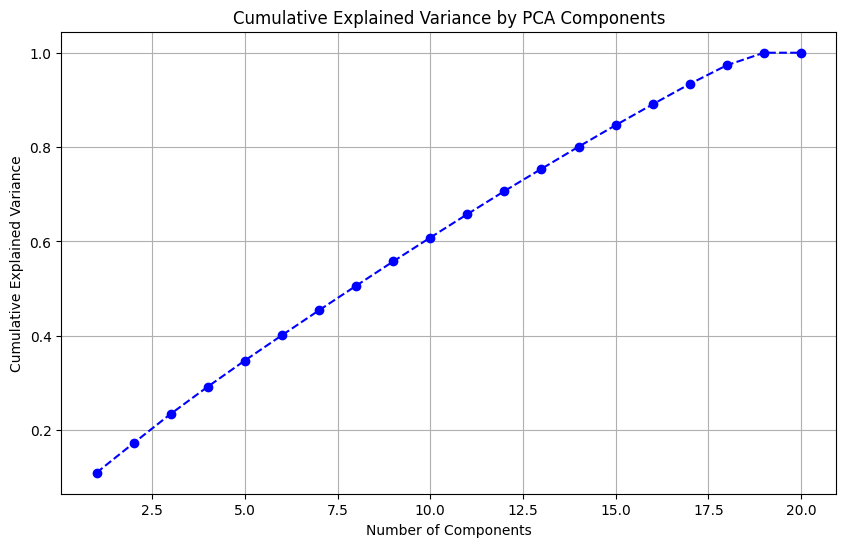

In [44]:
# Apply PCA to reduce dimensionality
pca = PCA()
hog_features_reduced = pca.fit_transform(hog_features_scaled)

# Plot the cumulative explained variance to determine the number of components
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [45]:
# capture 90% of the variance:
n_components = np.argmax(explained_variance_ratio >= 0.90) + 1
print(f"Number of components to capture 90% variance: {n_components}")

Number of components to capture 90% variance: 17


<ipython-input-46-5c7fc887e45d>:13: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method=method)


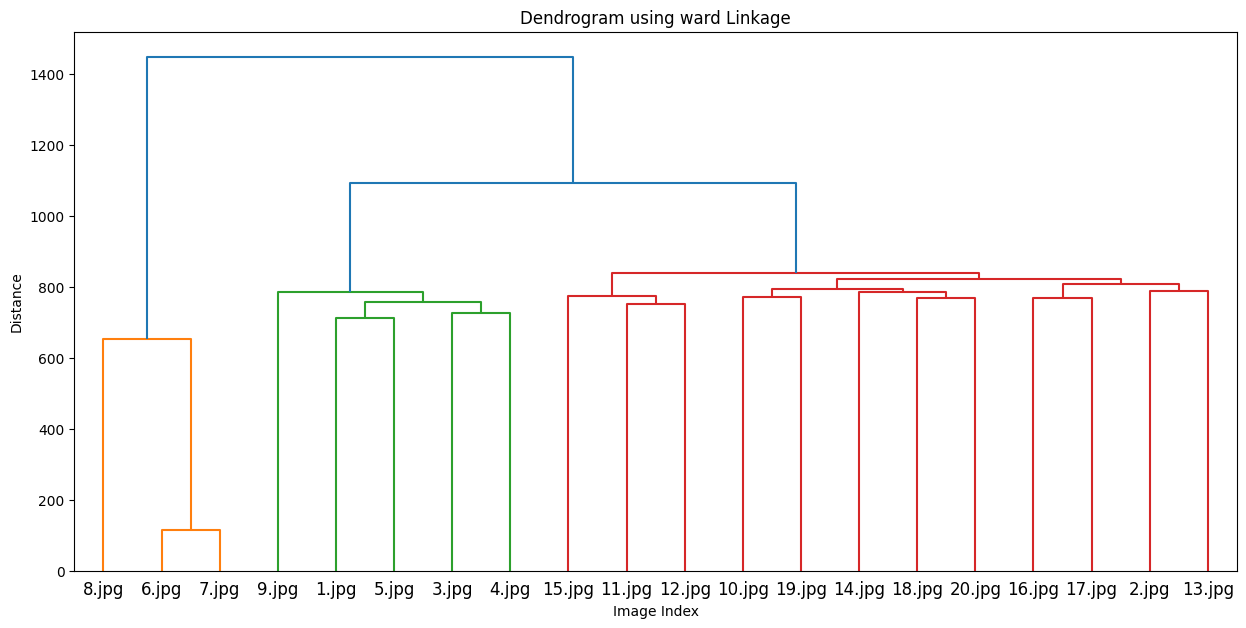

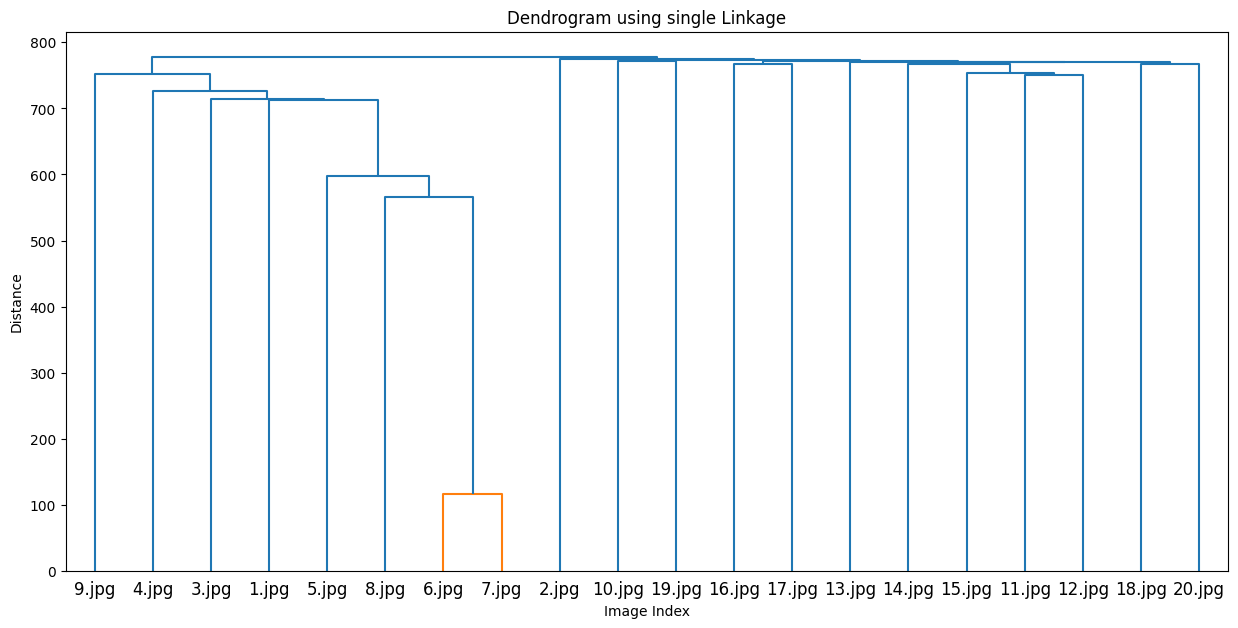

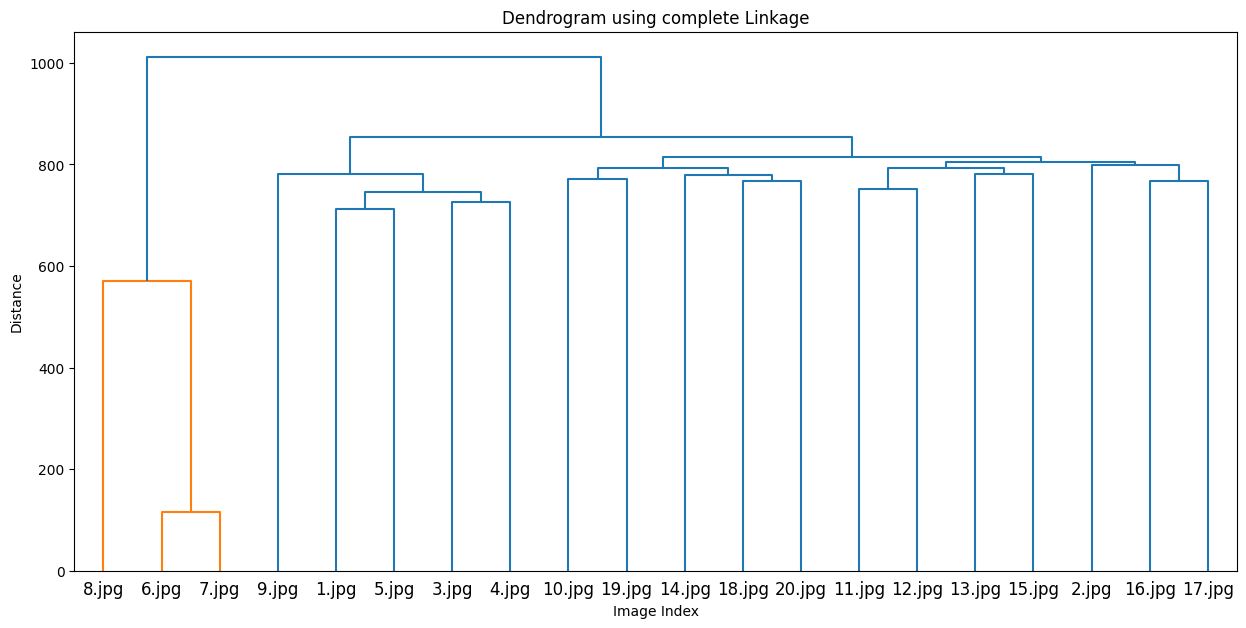

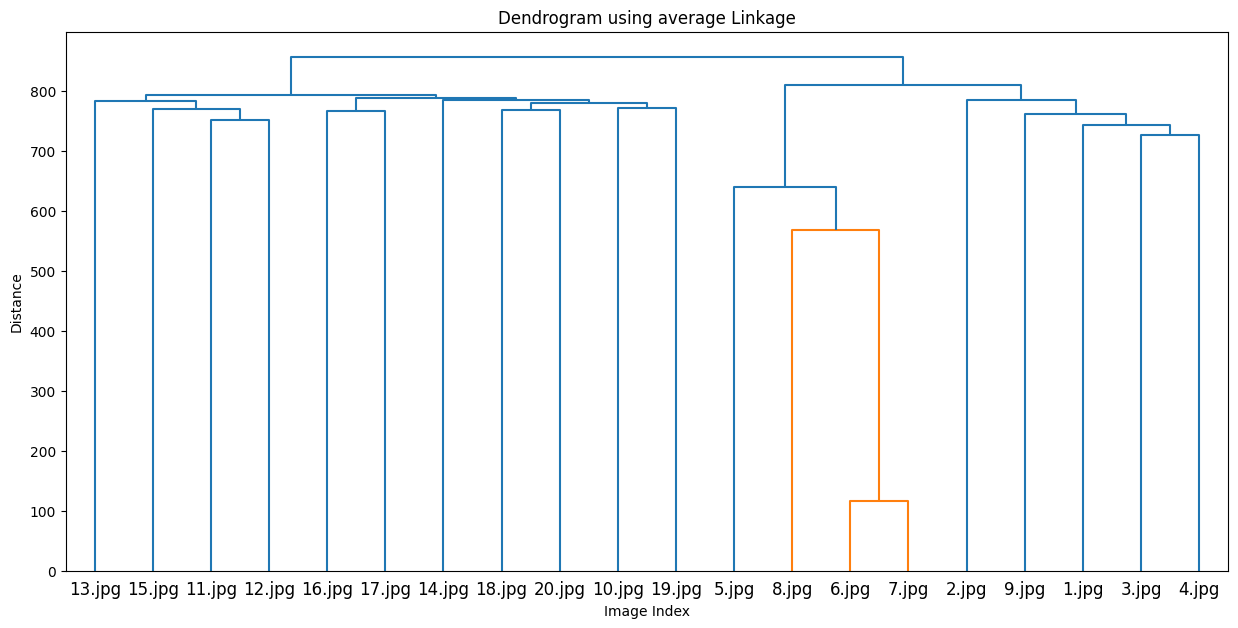

In [46]:
# Re-run PCA with the selected number of components
pca = PCA(n_components=17)
hog_features_reduced = pca.fit_transform(hog_features_scaled)

# Compute the distance matrix using Euclidean distance
distance_matrix = pdist(hog_features_reduced, metric='euclidean')
distance_matrix = squareform(distance_matrix)

# Apply hierarchical clustering using different linkage methods
linkage_methods = ['ward', 'single', 'complete', 'average']
for method in linkage_methods:
    plt.figure(figsize=(15, 7))
    Z = linkage(distance_matrix, method=method)
    dendrogram(Z, labels=image_files)
    plt.title(f'Dendrogram using {method} Linkage')
    plt.xlabel('Image Index')
    plt.ylabel('Distance')
    plt.show()

CNN based features

In [50]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

In [51]:
# Load the VGG16 model pre-trained on ImageNet without the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False)

# Image preprocessing and CNN feature extraction function
def extract_cnn_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize all images to 224x224
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = base_model.predict(img_data)
    return features.flatten()  # Flatten the feature map

In [52]:
# Extract CNN features from all images
cnn_features = []
for file in image_files:
    features = extract_cnn_features(os.path.join(image_folder, file))
    cnn_features.append(features)

# Convert list to numpy array
cnn_features = np.array(cnn_features)

# Standardize the features
scaler = StandardScaler()
cnn_features_scaled = scaler.fit_transform(cnn_features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


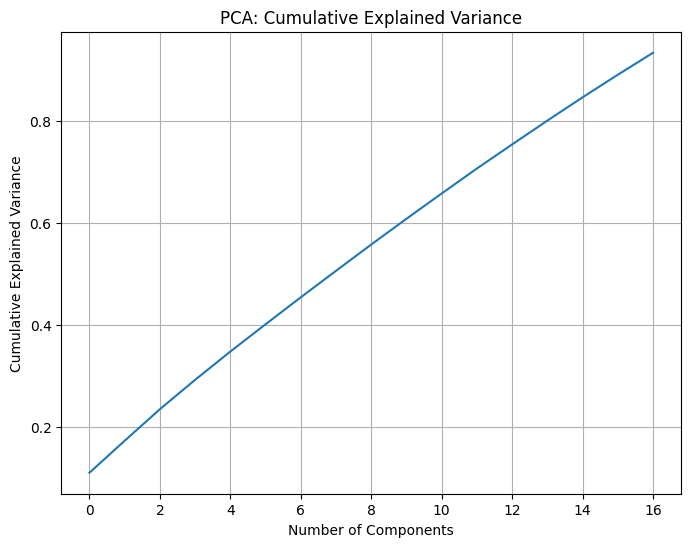

Number of components that explain 90% variance: 17


In [55]:
# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.grid()
plt.show()

# Get the number of components for 90% explained variance
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1  # +1 because index starts at 0
print(f"Number of components that explain 90% variance: {n_components_90}")

In [56]:
# PCA for dimensionality reduction
pca = PCA(n_components=17)
cnn_features_reduced = pca.fit_transform(cnn_features_scaled)

<ipython-input-57-a925df72bc79>:9: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method=method)


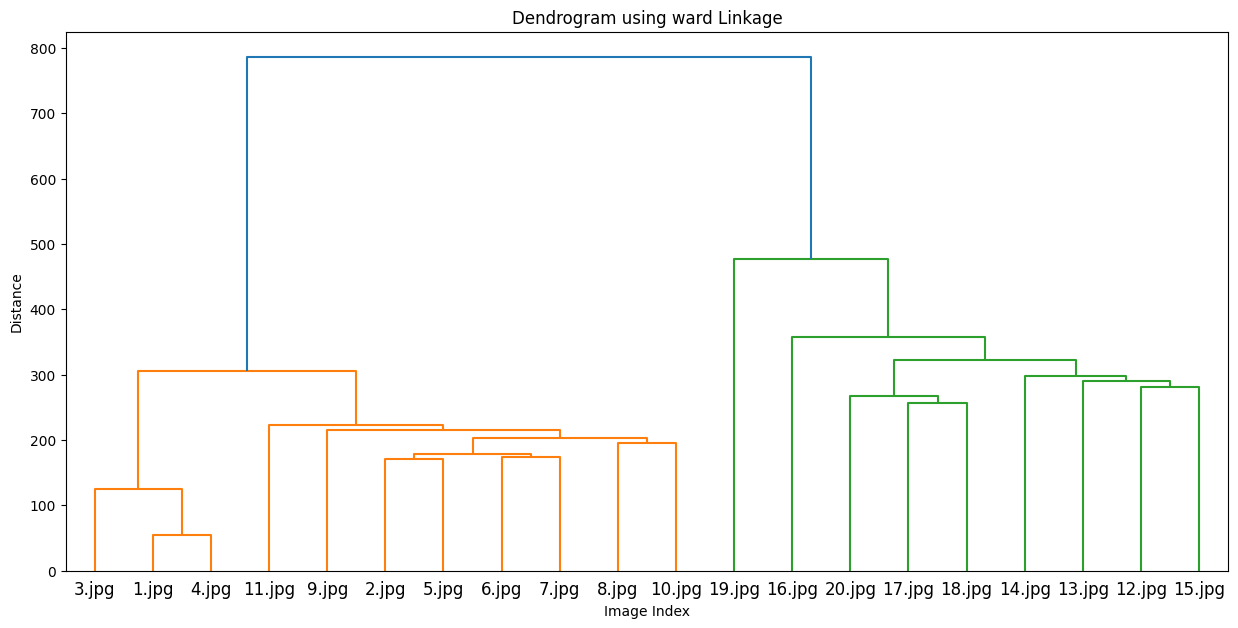

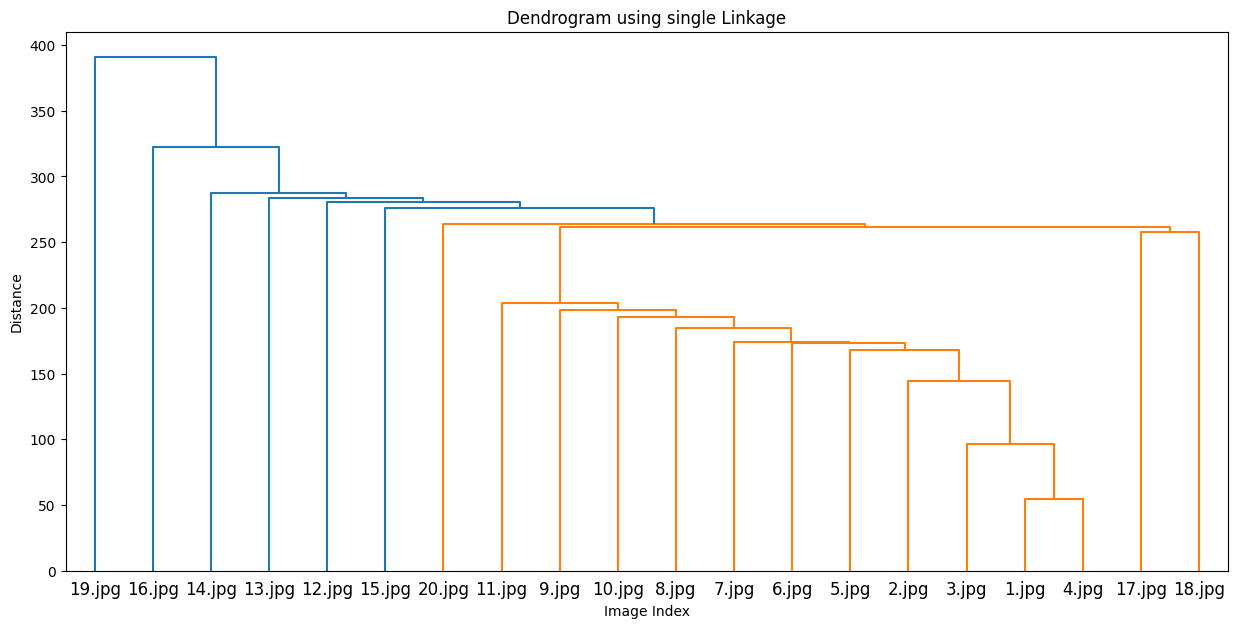

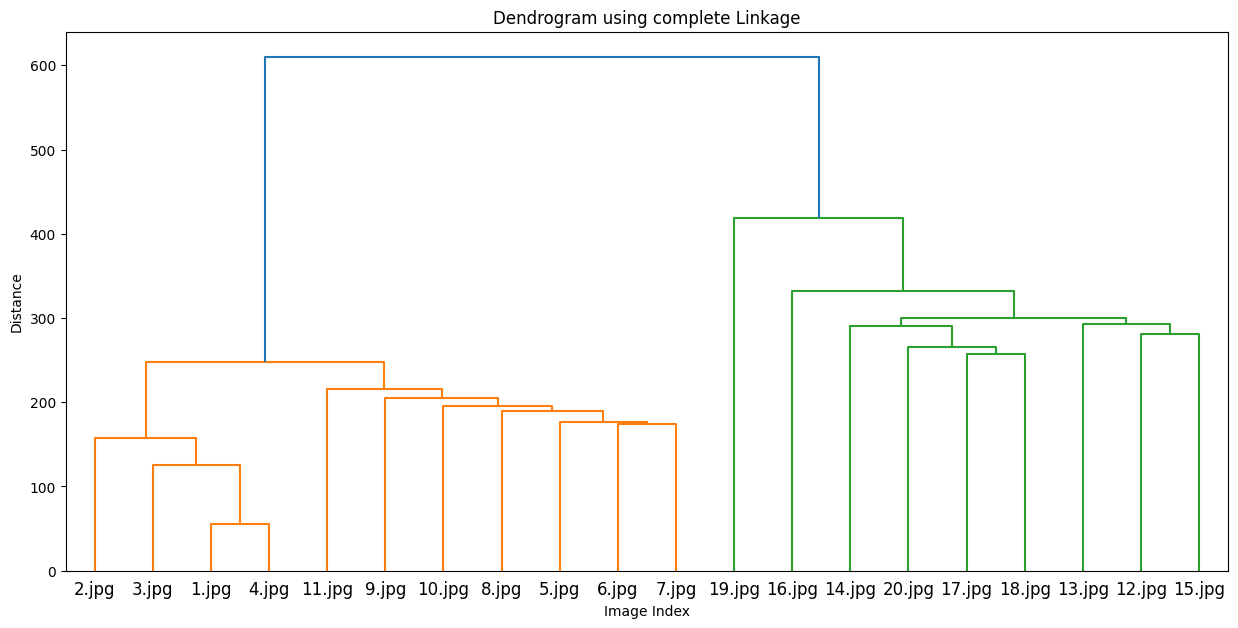

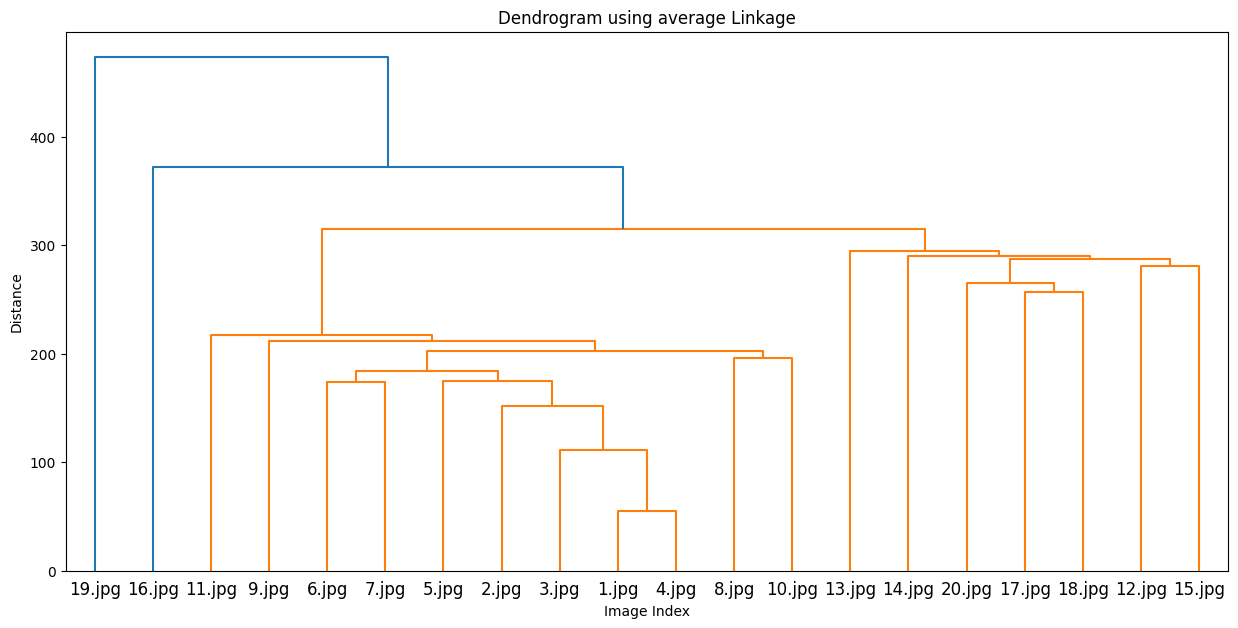

In [57]:
# Compute the distance matrix using Euclidean distance
distance_matrix = pdist(cnn_features_reduced, metric='euclidean')
distance_matrix = squareform(distance_matrix)

# Perform hierarchical clustering using different linkage methods
linkage_methods = ['ward', 'single', 'complete', 'average']
for method in linkage_methods:
    plt.figure(figsize=(15, 7))
    Z = linkage(distance_matrix, method=method)
    dendrogram(Z, labels=image_files)
    plt.title(f'Dendrogram using {method} Linkage')
    plt.xlabel('Image Index')
    plt.ylabel('Distance')
    plt.show()

In [59]:
from sklearn.cluster import AgglomerativeClustering

# Agglomerative Clustering with 17 components and 'ward' linkage
agg_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
labels = agg_cluster.fit_predict(cnn_features_reduced)

# Print or visualize the clustering labels for analysis
print("Cluster labels:", labels)

Cluster labels: [0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 2 0 0 3 0]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
